![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold , cross_val_score 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error as MSE

# Import any additional modules and start coding below
rentals= pd.read_csv('rental_info.csv')
print(rentals.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB
None


In [293]:
# Converting both date columns to datetime
rentals['rental_date'] = pd.to_datetime(rentals['rental_date'])
rentals['return_date'] = pd.to_datetime(rentals['return_date'])
rentals.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [294]:
# Creating a rental_length_days column
rentals['rental_length_days'] = rentals['return_date'] - rentals['rental_date']
# Getting the number of days with the time in consideration
rentals['rental_length_days'] = rentals['rental_length_days'].dt.days
rentals[['return_date', 'rental_date', 'rental_length_days']].head()

,return_date,rental_date,rental_length_days
0,2005-05-28 23:40:33+00:00,2005-05-25 02:54:33+00:00,3
1,2005-06-18 19:24:16+00:00,2005-06-15 23:19:16+00:00,2
2,2005-07-17 10:11:45+00:00,2005-07-10 04:27:45+00:00,7
3,2005-08-02 14:30:41+00:00,2005-07-31 12:06:41+00:00,2
4,2005-08-23 13:35:04+00:00,2005-08-19 12:30:04+00:00,4


In [295]:
# preprocessing data for machine learning
rentals['deleted_scenes'] = np.where(rentals['special_features'].str.contains('Deleted Scenes'),1,0)
rentals['behind_the_scenes'] = np.where(rentals['special_features'].str.contains('Behind the Scenes'),1,0)
rentals[['deleted_scenes', 'behind_the_scenes']]
print(rentals['deleted_scenes'].value_counts()) ; print(rentals['behind_the_scenes'].value_counts())

# Cross validating with the original column 
print(rentals['special_features'].str.contains('Behind the Scenes').value_counts())
print(rentals['special_features'].str.contains('Deleted Scenes').value_counts())
print(rentals.columns)
rentals.head()

0    7973
1    7888
Name: deleted_scenes, dtype: int64
1    8507
0    7354
Name: behind_the_scenes, dtype: int64
True     8507
False    7354
Name: special_features, dtype: int64
False    7973
True     7888
Name: special_features, dtype: int64
Index(['rental_date', 'return_date', 'amount', 'release_year', 'rental_rate',
       'length', 'replacement_cost', 'special_features', 'NC-17', 'PG',
       'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2',
       'rental_length_days', 'deleted_scenes', 'behind_the_scenes'],
      dtype='object')


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1


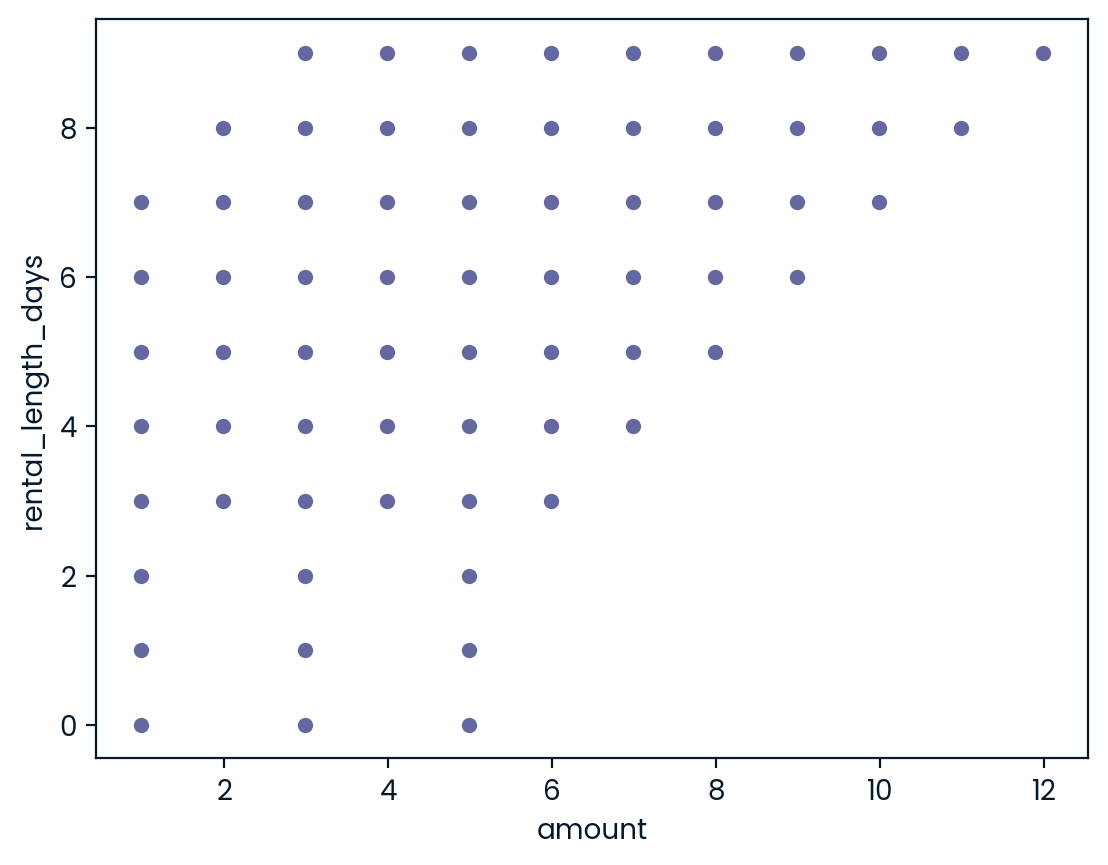

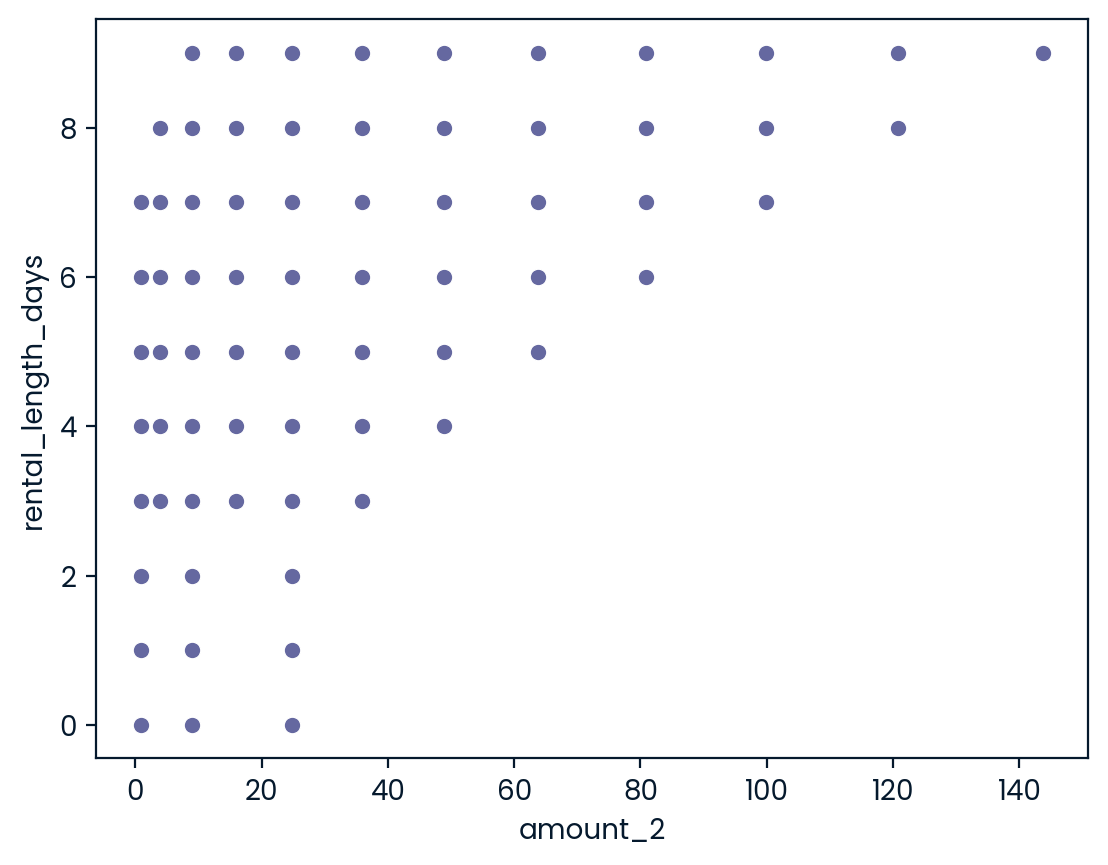

In [296]:
sns.scatterplot(data=rentals, x='amount', y='rental_length_days')
plt.show()
sns.scatterplot(data= rentals, x='amount_2', y='rental_length_days')
plt.show()

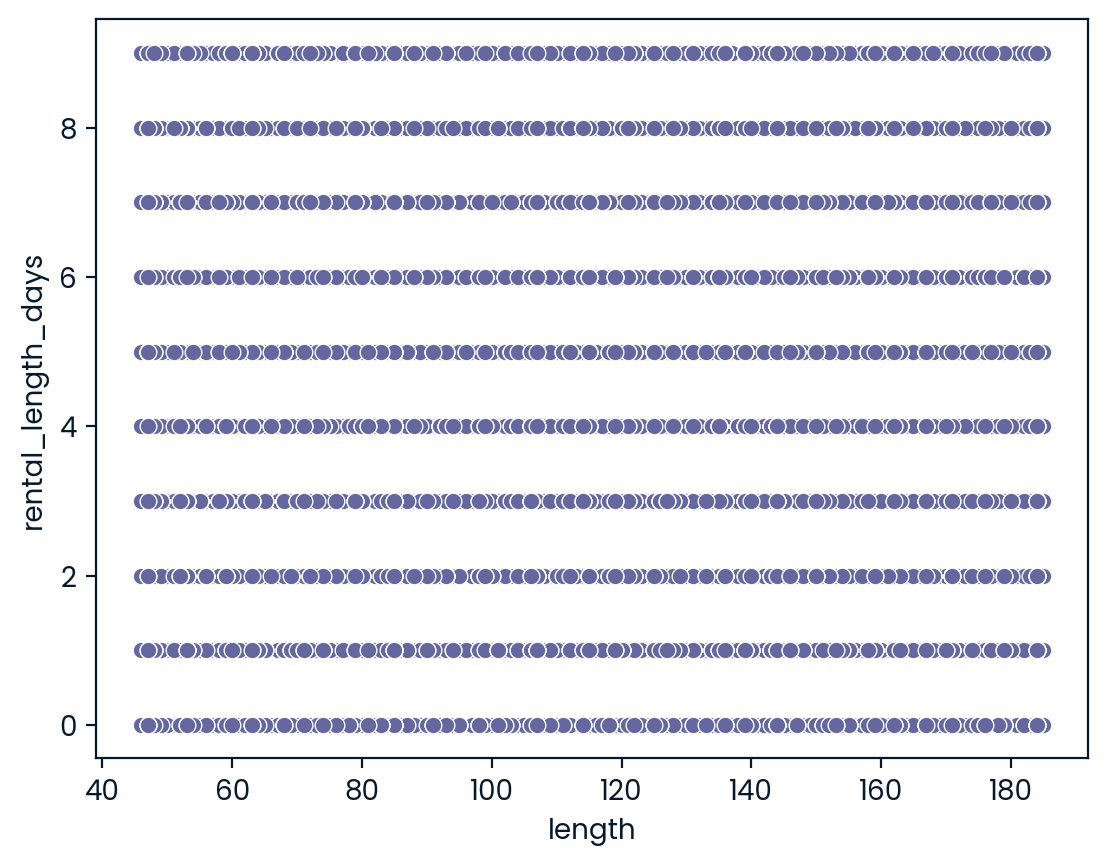

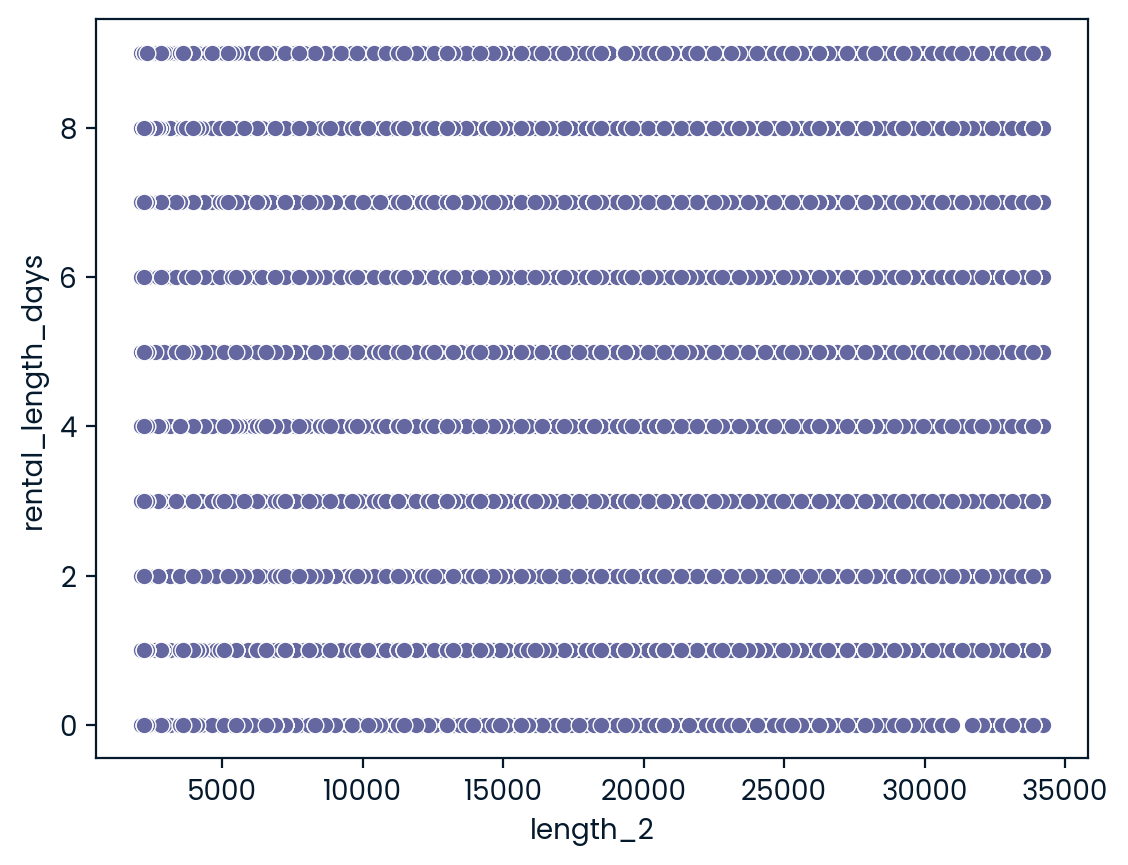

In [297]:
sns.scatterplot(data=rentals, x='length', y='rental_length_days')
plt.show()
sns.scatterplot(data= rentals, x='length_2', y='rental_length_days')
plt.show()

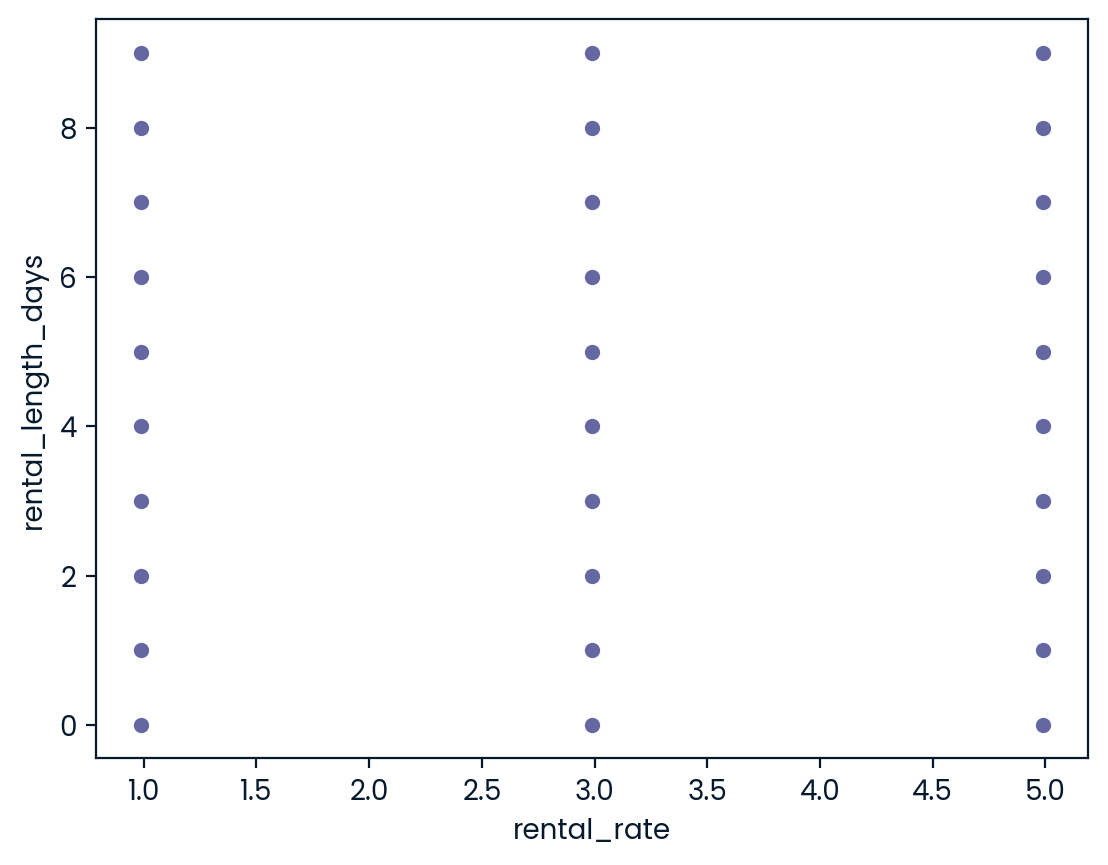

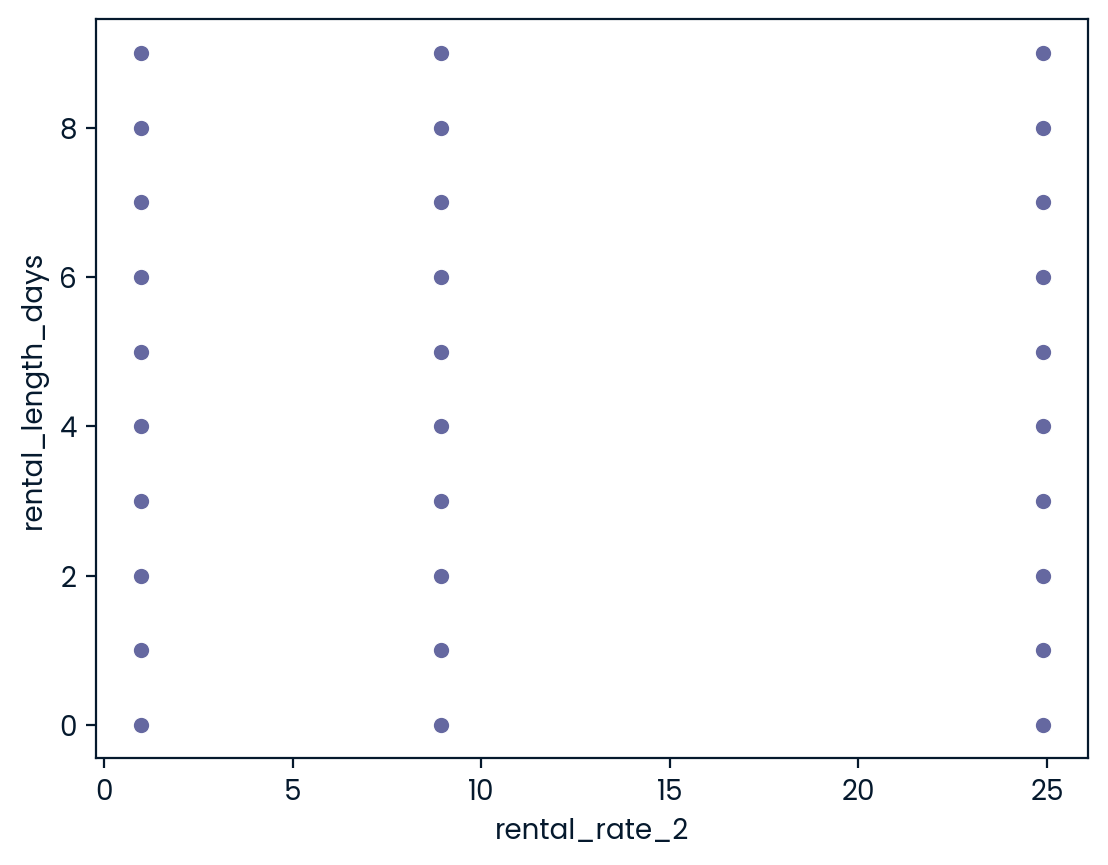

In [298]:
sns.scatterplot(data=rentals, x='rental_rate', y='rental_length_days')
plt.show()
sns.scatterplot(data= rentals, x='rental_rate_2', y='rental_length_days')
plt.show()

In [299]:
# Selecting features for machine learning
X = rentals.drop(['rental_date','return_date', 'special_features','rental_length_days'], axis = 1)
y = rentals['rental_length_days']
# Splitting the data into train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=9)
linreg = LinearRegression()
rge = Ridge(random_state=9)
ls = Lasso(random_state=9)
regressors = [('Linear Regression', linreg),
             ('Ridge Regression', rge ),
             ('Lasso Regression', ls )]
# Performing Cross Validation
kf = KFold(n_splits=6, shuffle= True, random_state=9)
print(rge.get_params()); print('\n', linreg.get_params()); print('\n', ls.get_params())
# Fitting, predicting test set and evaluating the model all in a loop
mse_reg = [] 
cv_score = []
print('\n')
# Without Cross Validation
for name, model in regressors : 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = MSE(y_test, y_pred)
    mse_reg.append(mse)
# With Cross Validation
for name, model in regressors : 
    cv_scores =  -cross_val_score(model , X_train, y_train, cv=kf, scoring = 'neg_mean_squared_error')
    mse_mean = np.mean(cv_scores)
    cv_score.append(mse_mean)
print(mse_reg) ; print('\n', cv_score)

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 9, 'solver': 'auto', 'tol': 0.0001}

 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

 {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 9, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


[2.9417238646975883, 2.9417585460802016, 3.8056884092652106]

 [2.849692342379713, 2.849689727239108, 3.681668945665351]


In [300]:
best_model = linreg
best_mse = cv_score[0]